# Summary

The goal of this notebook is to do an in-depth investigation of the different distributions of the three groupings we are using in Alameda and Contra Costa counties. It is used to obtain the figures and values in the "Characteristics" section of the case study. 

## Dataset Notes

We use census data which divides each county into a certain number of census tracts. For each census tract, we have percentage breakdowns of the residents on the basis of:

1. Ethnicity. There are 6 possible groupings. 

2. Health Insurance Status. We have converted the original data into a binary grouping. Either a househould has insurance or not. 

3. Poverty status. There are two possible groupings. Either a househould is above or below the federal poverty line. 

For any grouping, there is a number of people in each census tract for which the status is not known. For example, some fraction of a census tract might not have its race identified. For this case, we simply allocate the "Unknown" population according to the proportion of people in each census tract with known groupings. For example, if a census tract has 400 people without health insurance, 400 with, and 200 unknown, we would consider it to have 500 people without health insurance, and 500 with. 

# Preprocessing

## Load Packages

In [1]:
import sys
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
from matplotlib import colorbar
from matplotlib.colors import Normalize

In [3]:
plt.rcParams['figure.figsize'] = [20, 12]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 36.0
plt.rcParams['xtick.labelsize'] = 36.0
plt.rcParams['ytick.labelsize'] = 36.0

## Load Data

In [4]:
DATA_PATH = 'all-data/'
# Load tract-facility distance matrix, computed via the Google Maps API. 
# Distances refer to the driving distance between pairs of locations. 
gmaps_distance_matrix = pd.read_csv(DATA_PATH + 'all_tract_facility_travel_distance_matrix.csv')

# Remove unnecessary first column.
gmaps_distance_matrix = gmaps_distance_matrix.iloc[:, 1:].copy()

# Convert to numpy array, and divide by 1000 to convert meters to kilometers. 
tract_facility_distance_matrix = np.array(gmaps_distance_matrix)[:, :] / 1000.0

In [5]:
tract_facility_distance_matrix.shape

(567, 25)

In [6]:
# Load population data. 

race_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/ethnicity_split_all.csv')
health_ins_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/health_ins_split_all.csv')
income_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/income_split_all.csv')

In [7]:
# Load facilities data.

al_fac_df = pd.read_csv(DATA_PATH + 'hospital-data/alameda-emergency-facilites.csv').iloc[:18, :].copy()
cc_fac_df = pd.read_csv(DATA_PATH + 'hospital-data/cc-healthcare-dataset.csv')
al_facilites_long_lats = np.array(al_fac_df[['LONGITUDE', 'LATITUDE']])
cc_facilites_long_lats = np.array(cc_fac_df[['LONGITUDE', 'LATITUDE']])
facilites_long_lats = np.vstack((al_facilites_long_lats, cc_facilites_long_lats))
num_beds_arr = list(al_fac_df['TOTAL_NUMBER_BEDS']) + list(cc_fac_df['TOTAL_NUMBER_BEDS'])

In [31]:
al_fac_df

OSHPD_ID                                      FACILITY_NAME  LICENSE_NUM  \
0   106010735                                   ALAMEDA HOSPITAL    140000002   
1   106010739  ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...    140000004   
2   106010776  CHILDRENS HOSPITAL AND RESEARCH CENTER AT OAKLAND    140000015   
3   106010846                                  HIGHLAND HOSPITAL    140000046   
4   106010937                   ALTA BATES SUMMIT MEDICAL CENTER    140000284   
5   106010967                                  ST. ROSE HOSPITAL    140000107   
6   106010987                      WASHINGTON HOSPITAL - FREMONT    140000116   
7   106013619                               SAN LEANDRO HOSPITAL    550002039   
8   106014050                          VALLEYCARE MEDICAL CENTER    140000114   
9   106014132               KAISER FOUNDATION HOSPITAL - FREMONT    140000053   
10  106014233                                EDEN MEDICAL CENTER    140000030   
11  106014326      KAISER FOUNDATION HOSPITAL - OAKLAND/RICHMOND    140000052   
12  106014337           KAISER FOUNDATION HOSPITAL - SAN LEANDRO    550002678   
13  106010811                                  FAIRMONT HOSPITAL    140000046   
14  106010844    ALTA BATES SUMMIT MEDICAL CENTER-HERRICK CAMPUS    140000004   
15  106010887          KINDRED HOSPITAL - SAN FRANCISCO BAY AREA    140000066   
16  106010983                           VALLEY MEMORIAL HOSPITAL    140000114   

      FACILITY_LEVEL_DESC                 DBA_ADDRESS1       DBA_CITY  \
0         Parent Facility             2070 CLINTON AVE        ALAMEDA   
1         Parent Facility            2450 ASHBY AVENUE       BERKELEY   
2         Parent Facility              747 52ND STREET        OAKLAND   
3         Parent Facility        1411 EAST 31ST STREET        OAKLAND   
4         Parent Facility         350 HAWTHORNE AVENUE        OAKLAND   
5         Parent Facility        27200 CALAROGA AVENUE        HAYWARD   
6         Parent Facility            2000 MOWRY AVENUE        FREMONT   
7         Parent Facility       13855 EAST 14TH STREET    SAN LEANDRO   
8         Parent Facility  5555 WEST LAS POSITAS BLVD.     PLEASANTON   
9         Parent Facility    39400 PASEO PADRE PARKWAY        FREMONT   
10        Parent Facility         20103 LAKE CHABOT RD  CASTRO VALLEY   
11        Parent Facility       275 W. MACARTHUR BLVD.        OAKLAND   
12        Parent Facility           2500 MERCED STREET    SAN LEANDRO   
13  Consolidated Facility     15400 FOOTHILL BOULEVARD    SAN LEANDRO   
14  Consolidated Facility              2001 DWIGHT WAY       BERKELEY   
15        Parent Facility          2800 BENEDICT DRIVE    SAN LEANDRO   
16  Consolidated Facility    1111 E. STANLEY BOULEVARD      LIVERMORE   

    DBA_ZIP_CODE  COUNTY_CODE COUNTY_NAME ER_SERVICE_LEVEL_DESC  \
0          94501            1     ALAMEDA     Emergency - Basic   
1          94705            1     ALAMEDA     Emergency - Basic   
2          94609            1     ALAMEDA     Emergency - Basic   
3          94602            1     ALAMEDA     Emergency - Basic   
4          94609            1     ALAMEDA     Emergency - Basic   
5          94545            1     ALAMEDA     Emergency - Basic   
6          94538            1     ALAMEDA     Emergency - Basic   
7          94578            1     ALAMEDA     Emergency - Basic   
8          94588            1     ALAMEDA     Emergency - Basic   
9          94538            1     ALAMEDA     Emergency - Basic   
10         94546            1     ALAMEDA     Emergency - Basic   
11         94611            1     ALAMEDA     Emergency - Basic   
12         94577            1     ALAMEDA     Emergency - Basic   
13         94578            1     ALAMEDA                  None   
14         94704            1     ALAMEDA                  None   
15         94577            1     ALAMEDA                  None   
16         94550            1     ALAMEDA                  None   

    TOTAL_NUMBER_BEDS FA

In [32]:
total_fac_df = pd.DataFrame(columns = ['LONGITUDE', 'LATITUDE', 'FACILITY_NAME', 'TOTAL_NUMBER_BEDS'])

In [35]:
total_fac_df['LONGITUDE'] = facilites_long_lats[:, 0]
total_fac_df['LATITUDE'] = facilites_long_lats[:, 1]
total_fac_df['TOTAL_NUMBER_BEDS'] = num_beds_arr

In [39]:
total_fac_df['FACILITY_NAME'] = list(al_fac_df['FACILITY_NAME']) + list(cc_fac_df['FACNAME'])

In [8]:
total_population_by_tract =\
        np.copy(health_ins_split_df_all[health_ins_split_df_all['Variable'] == 'No_Health_Ins_ACS_10_14']['Value']) +\
        np.copy(health_ins_split_df_all[health_ins_split_df_all['Variable'] == 'One_Plus_Health_Ins']['Value'])

Below is a utility function for saving matplotlib figures. This avoids issues of having to pre-make a directory in which to put your fiugre.

In [9]:
def plt_savefig_safe(savepath):
    '''
    Makes a new folder with the savepath directory, if it does not exist. 
    Then, saves the figure. 
    
    savepath: string. The path by which to save a figure.
    '''
    index_of_last_slash = savepath.rfind('/')
    savedir = savepath[:index_of_last_slash + 1]

    directory = os.path.dirname(savedir)

    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(savepath)

# Compute General Statistics

* What are the travel distances like under the current set of facilities? How does this break down by group?

* What are the percentages of people who are uninsured, people of color, etc. in our dataset? 

In [10]:
tract_facility_distance_matrix.shape

(567, 25)

In [11]:
NUM_FACILITIES = tract_facility_distance_matrix.shape[1]

In [12]:
open_fac_ids = [x for x in range(NUM_FACILITIES) if x < 13 or x > 16]

In [13]:
open_fac_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24]

In [14]:
len(open_fac_ids)

21

## Histograms of Current Travel Distances

Make a histogram showing the distribution of travel distances under current facilities (including Alta Bates). 

We first assign each census tract to the nearest open facility. By taking `tract_facility_distance_matrix[:, open_fac_ids]`, we include only the columns which correspond to open facilities. Taking `np.min` along axis 1 (the left-to-right axis, or the axis going through the columns) corresponds to taking the minimum entry of each row. This gives the distance from each tract to the nearest open facility.

In [40]:
current_tract_travel_distances = np.copy(np.min(tract_facility_distance_matrix[:, open_fac_ids], axis=1))

In [41]:
population_array_ints = [int(x) for x in total_population_by_tract]

Currently we have travel distances for each tract, as well as each tract's population. Creating an array where there is a single float for each resident of the county, corresponding to their distance to the nearest facility, is the correct input to the travel distance histogram.

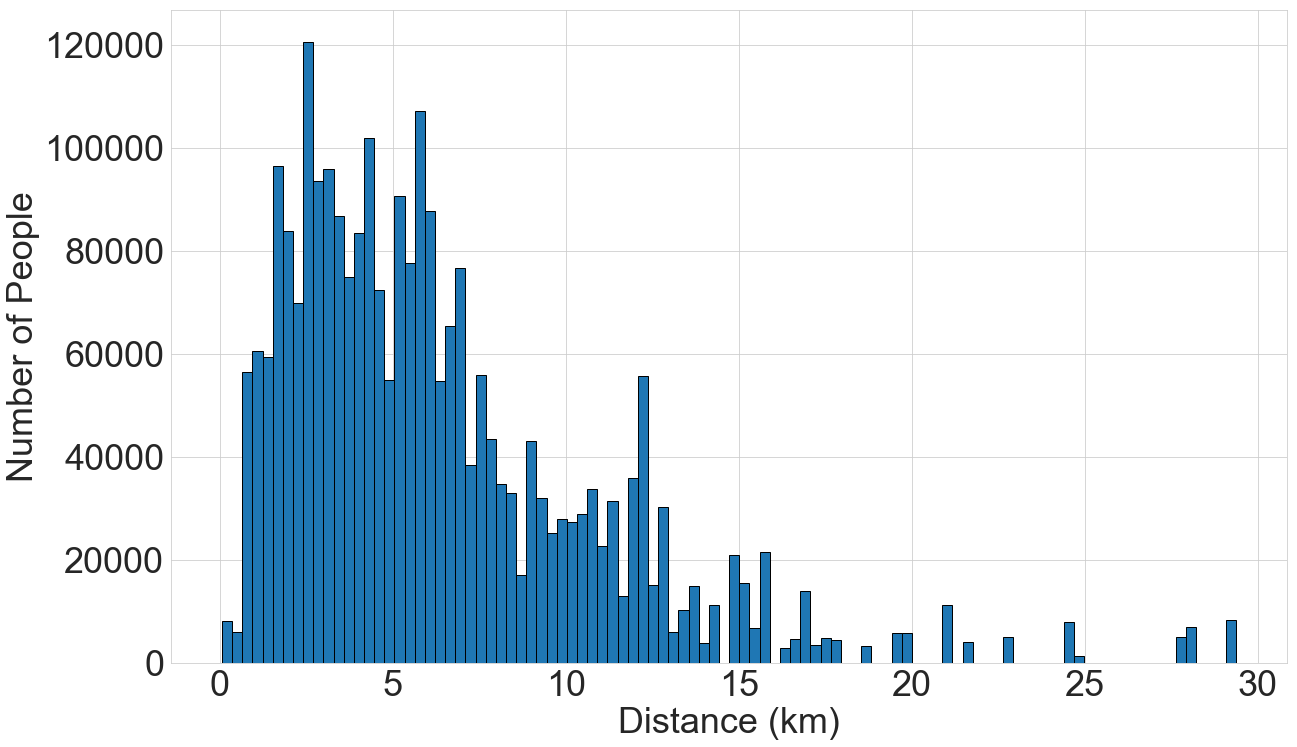

In [56]:
plt.hist(np.repeat(current_tract_travel_distances, population_array_ints), bins=100, ec='k')
plt.xlabel('Distance (km)')
plt.ylabel('Number of People');
plt_savefig_safe('visualizations/alameda-cc-characteristics/current_travel_dist_histogram.png');

How does this compare to travel distance for Alta Bates customers? 

In [99]:
def get_facility_tract_ids(fac_number, open_fac_ids):
    assignments_relative_indices = np.argmin(tract_facility_distance_matrix[:, open_fac_ids], axis=1)
    assignments_abs_indices = np.array([open_fac_ids[x] for x in assignments_relative_indices])
    return np.where(assignments_abs_indices == fac_number)

In [105]:
ab_customers_tract_ids = get_facility_tract_ids(1, cur_facs)

In [106]:
ab_tract_distances = tract_facility_distance_matrix[ab_customers_tract_ids, 1]
ab_tract_populations = total_population_by_tract[ab_customers_tract_ids]

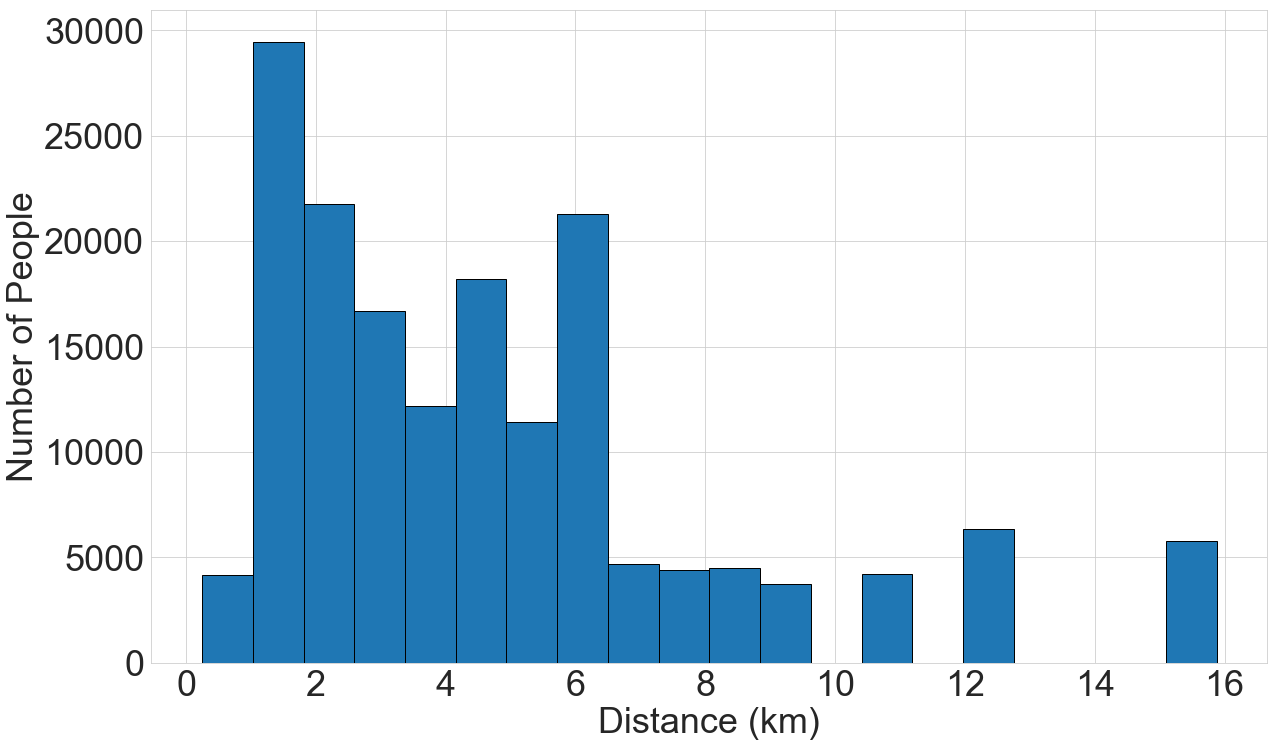

In [107]:
plt.hist(np.repeat(ab_tract_distances, ab_tract_populations.astype(int)), bins=20, ec='k')
plt.xlabel('Distance (km)')
plt.ylabel('Number of People');
plt_savefig_safe('visualizations/alameda-cc-characteristics/current_travel_dist_histogram_ab_customers.png');

## Percentages by Demographic

What are the overall percentages of the population who belong to each particular group? 

### Percentages in overall dataset

In [15]:
def get_grouping_percentages(split_grouping_df, overall_population):
    '''
    Compute the percentage of each group across the categories given. 
    Return a dictionary where KEY = Group name, VALUE = Population
    
    split_grouping_df: Grouping dataframe with a "Variable" and "Value"
    column. "Variable" is the group name, and "Value" is the population.
    
    overall_population: An integer. Total population of the dataset.
    '''
    uq_group_names = list(split_grouping_df['Variable'].unique())
    out_dict = {}
    for group_name in uq_group_names: 
        group_count = np.sum(split_grouping_df[split_grouping_df['Variable'] == group_name]['Value'])
        out_dict[group_name] = group_count
        out_dict[group_name + '_Percentage'] = float(group_count) / overall_population
    population_counts = [out_dict[k] for k in out_dict.keys() if '_Percentage' not in k]
    population_percentages = [out_dict[k] for k in out_dict.keys() if '_Percentage' in k]
    
    assert np.abs(int(sum(population_counts)) - int(overall_population)) < 10,\
            'Incorrect population of {}. Should be {}'.format(int(sum(population_counts)), int(overall_population))
    assert np.isclose(1.0, sum(population_percentages)),\
            'Percentages add up to {}'.format(sum(population_percentages))
    return out_dict

In [29]:
get_grouping_percentages(health_ins_split_df_all, np.sum(total_population_by_tract))

{'No_Health_Ins_ACS_10_14': 304220.3592932215,
 'No_Health_Ins_ACS_10_14_Percentage': 0.11521141860877757,
 'One_Plus_Health_Ins': 2336319.6407067785,
 'One_Plus_Health_Ins_Percentage': 0.8847885813912224}

In [30]:
get_grouping_percentages(race_split_df_all, np.sum(total_population_by_tract))

{'NH_AIAN_alone_ACS_10_14': 11464.989096268402,
 'NH_AIAN_alone_ACS_10_14_Percentage': 0.00434191078198717,
 'NH_Asian_alone_ACS_10_14': 791341.2110772079,
 'NH_Asian_alone_ACS_10_14_Percentage': 0.29968915868618085,
 'NH_Blk_alone_ACS_10_14': 443625.9746682064,
 'NH_Blk_alone_ACS_10_14_Percentage': 0.16800577710173162,
 'NH_NHOPI_alone_ACS_10_14': 30071.100911874135,
 'NH_NHOPI_alone_ACS_10_14_Percentage': 0.011388239114678867,
 'NH_SOR_alone_ACS_10_14': 11026.344559325797,
 'NH_SOR_alone_ACS_10_14_Percentage': 0.004175791527235261,
 'NH_White_alone_ACS_10_14': 1353011.3796871174,
 'NH_White_alone_ACS_10_14_Percentage': 0.5123995014986016}

In [18]:
get_grouping_percentages(income_split_df_all, np.sum(total_population_by_tract))

{'Prs_Blw_Pov_Lev_ACS_10_14': 311362,
 'Prs_Blw_Pov_Lev_ACS_10_14_Percentage': 0.11791603232672104,
 'Above_poverty_level': 2329178,
 'Above_poverty_level_Percentage': 0.8820839676732789}

In [19]:
all_race_names = list(race_split_df_all['Variable'].unique())

In [20]:
sum(race_split_df_all[race_split_df_all['Variable'] == all_race_names[-2]]['Value'])

11026.344559325798

In [21]:
sum(race_split_df_all['Value'])

2640540.9999999967

In [22]:
sum(health_ins_split_df_all['Value'])

2640540.0

In [23]:
sum(income_split_df_all['Value'])

2640540

### Percentages for just Alta Bates Customers

What if we ask the same question, but restrict ourselves purely to Alta Bates customers? 

In [24]:
def get_ab_grouping_percentages(split_grouping_df, census_tract_ids, overall_population):
    '''
    Compute the percentage of each group across the categories given. 
    Restricted only to current customers of Alta Bates.
    Return a dictionary where KEY = Group name, VALUE = Population
    
    split_grouping_df: Grouping dataframe with a "Variable" and "Value"
    column. "Variable" is the group name, and "Value" is the population.
    census_tract_ids: List of integers. The IDs of the census tracts to restrict to. 
    overall_population: An integer. Total population of the dataset.
    '''
    uq_group_names = list(split_grouping_df['Variable'].unique())
    out_dict = {}
    for group_name in uq_group_names: 
        group_rows = pd.DataFrame.copy(split_grouping_df[split_grouping_df['Variable'] == group_name])
        group_count = np.sum(group_rows.iloc[census_tract_ids]['Value'])
        out_dict[group_name] = group_count
        out_dict[group_name + '_Percentage'] = float(group_count) / overall_population
    return out_dict

In [41]:
get_ab_grouping_percentages(health_ins_split_df_all, ab_customers_tract_ids, 
                            np.sum(total_population_by_tract[ab_customers_tract_ids]))

{'No_Health_Ins_ACS_10_14': 11173.567717987651,
 'No_Health_Ins_ACS_10_14_Percentage': 0.06617334437639634,
 'One_Plus_Health_Ins': 157679.43228201236,
 'One_Plus_Health_Ins_Percentage': 0.9338266556236038}

In [68]:
get_ab_grouping_percentages(race_split_df_all, ab_customers_tract_ids, 
                            np.sum(total_population_by_tract[ab_customers_tract_ids]))

{'NH_AIAN_alone_ACS_10_14': 513.4667790267289,
 'NH_AIAN_alone_ACS_10_14_Percentage': 0.0030409100165630985,
 'NH_Asian_alone_ACS_10_14': 36226.396349144205,
 'NH_Asian_alone_ACS_10_14_Percentage': 0.21454399003360441,
 'NH_Blk_alone_ACS_10_14': 13419.301342038274,
 'NH_Blk_alone_ACS_10_14_Percentage': 0.07947327759671592,
 'NH_NHOPI_alone_ACS_10_14': 324.0,
 'NH_NHOPI_alone_ACS_10_14_Percentage': 0.0019188288037523763,
 'NH_SOR_alone_ACS_10_14': 903.2621824629543,
 'NH_SOR_alone_ACS_10_14_Percentage': 0.005349399669907874,
 'NH_White_alone_ACS_10_14': 117472.57334732784,
 'NH_White_alone_ACS_10_14_Percentage': 0.6957091277461924}

In [69]:
get_ab_grouping_percentages(income_split_df_all, ab_customers_tract_ids, 
                            np.sum(total_population_by_tract[ab_customers_tract_ids]))

{'Prs_Blw_Pov_Lev_ACS_10_14': 23074,
 'Prs_Blw_Pov_Lev_ACS_10_14_Percentage': 0.1366514068450072,
 'Above_poverty_level': 145779,
 'Above_poverty_level_Percentage': 0.8633485931549928}

### Total Number of Alta Bates Customers

In [72]:
np.sum(total_population_by_tract[ab_customers_tract_ids])

168853.0

# Compute Correlations

What are the correlations of the different demographics, such as uninsured vs below poverty line?

## Set up functions

In [73]:
from scipy.stats import pearsonr

In [78]:
def get_var_value_col_names(split_grouping_df): 
    '''
    Helper function which gets the column names for "value" and "varible"
    in a dataframe. 
    
    split_grouping_df: Pandas dataframe, typically a grouping of the population by some
    demographic characteristic, e.g. income. 
    '''
    col_names = split_grouping_df.columns.values
    val_col_name = [x for x in col_names if 'alue' in x]
    vrbl_col_name = [x for x in col_names if 'ariable' in x]
    return val_col_name[0], vrbl_col_name[0]

In [79]:
def get_total_population(split_grouping_df, num_census_tracts): 
    '''
    split_grouping_df: A pandas dataframe giving the population of each group at each ID. 
    A split grouping df corresponds to a single type of grouping - e.g. income or race. 
    
    num_census_tracts: An integer giving the total number of census tracts. 
    '''
    value_col_name, var_col_name = get_var_value_col_names(split_grouping_df)
    num_groups = len(split_grouping_df[var_col_name].unique().tolist())
    
    sorted_df = split_grouping_df.sort_values(by='Latitude')
    
    total_populations = np.zeros(shape=(num_census_tracts,))
    for i in range(num_census_tracts): 
        low_index = i * num_groups
        high_index = (i + 1) * num_groups
        total_populations[i] = sum(sorted_df.iloc[low_index:high_index][value_col_name])
    return total_populations

In [80]:
def get_tract_percentage_arrs(split_grouping_df, total_population_by_tract): 
    '''
    split_grouping_df: A pandas dataframe giving the population of each group at each ID. 
    A split grouping df corresponds to a single type of grouping - e.g. income or race. 
    total_population_by_tract: 1D array of integers or floats. The population of each tract.
    
    Returns a stack of vectors, each of which gives the percent of a group at each census tract, 
    divided by the total population at that census tract. 
    I.e. v = [v_1, ..., v_567], where v_1 = #of residents of tract 1 in group v, and so on. 
    '''
    value_col_name, var_col_name = get_var_value_col_names(split_grouping_df)

    uq_group_names = split_grouping_df[var_col_name].unique().tolist()
    
    total_pop_arr = total_population_by_tract
    #get_total_population(split_grouping_df, len(total_population_by_tract))
    
    group_counts_lists = []
    for group_name in uq_group_names: 
        group_df_sorted = split_grouping_df[split_grouping_df[var_col_name] == group_name].copy()
        group_pop_counts = np.copy(group_df_sorted[value_col_name])
        group_counts_lists.append(np.divide(group_pop_counts, total_population_by_tract))
    out_arrs = np.vstack(group_counts_lists)
    assert np.allclose(np.sum(out_arrs, axis=0), np.ones(shape=(len(total_population_by_tract),)), 
                       rtol=1e-2, atol=1e-2)
    return uq_group_names, out_arrs

In [81]:
def get_fractional_averaging_arrs(split_grouping_df): 
    '''
    split_grouping_df: A pandas dataframe giving the population of each group at each ID. 
    A split grouping df corresponds to a single type of grouping - e.g. income or race. 
    
    Returns a stack of vectors, each of which gives the fraction of the group at each census tract.
    I.e. v = [v_1, ..., v_567], where v_1 = #percent of group v at tract 1, and so on. 
    So sum(v) = 1, always.
    '''
    value_col_name, var_col_name = get_var_value_col_names(split_grouping_df)
    uq_group_names = split_grouping_df[var_col_name].unique().tolist()
    
    group_counts_lists = []
    for group_name in uq_group_names: 
        group_df_sorted = split_grouping_df[split_grouping_df[var_col_name] == group_name].sort_values(by='Latitude')
        group_pop_counts = np.copy(group_df_sorted[value_col_name])
        total_group_pop = np.sum(group_pop_counts)
        group_counts_lists.append(np.divide(group_pop_counts, total_group_pop))
    return uq_group_names, np.vstack(group_counts_lists)

In [82]:
def get_population_arrs(split_grouping_df): 
    '''
    No averaging out by population.
    '''
    value_col_name, var_col_name = get_var_value_col_names(split_grouping_df)
    uq_group_names = split_grouping_df[var_col_name].unique().tolist()
    num_tracts = len(value_col_name) / len(uq_group_names)
    
    total_pop_arr = get_total_population(split_grouping_df, num_tracts)
    
    group_counts_lists = []
    for group_name in uq_group_names: 
        group_df_sorted = split_grouping_df[split_grouping_df[var_col_name] == group_name].sort_values(by='Latitude')
        group_pop_counts = np.copy(group_df_sorted[value_col_name])
        group_counts_lists.append(group_pop_counts)
    return uq_group_names, np.vstack(group_counts_lists)

### Compute correlations for both counties combined

If we treat the combined datasets for both counties as one large datasets, what are the population correlations?

In [83]:
race_names, race_percent_arrs = get_tract_percentage_arrs(race_split_df_all, total_population_by_tract)
income_names, income_arrs = get_tract_percentage_arrs(income_split_df_all, total_population_by_tract)
health_ins_names, health_ins_arrs = get_tract_percentage_arrs(health_ins_split_df_all, total_population_by_tract)
all_groups_tract_fractions = np.vstack((race_percent_arrs, income_arrs, health_ins_arrs))

In [84]:
all_group_names = race_names + income_names + health_ins_names

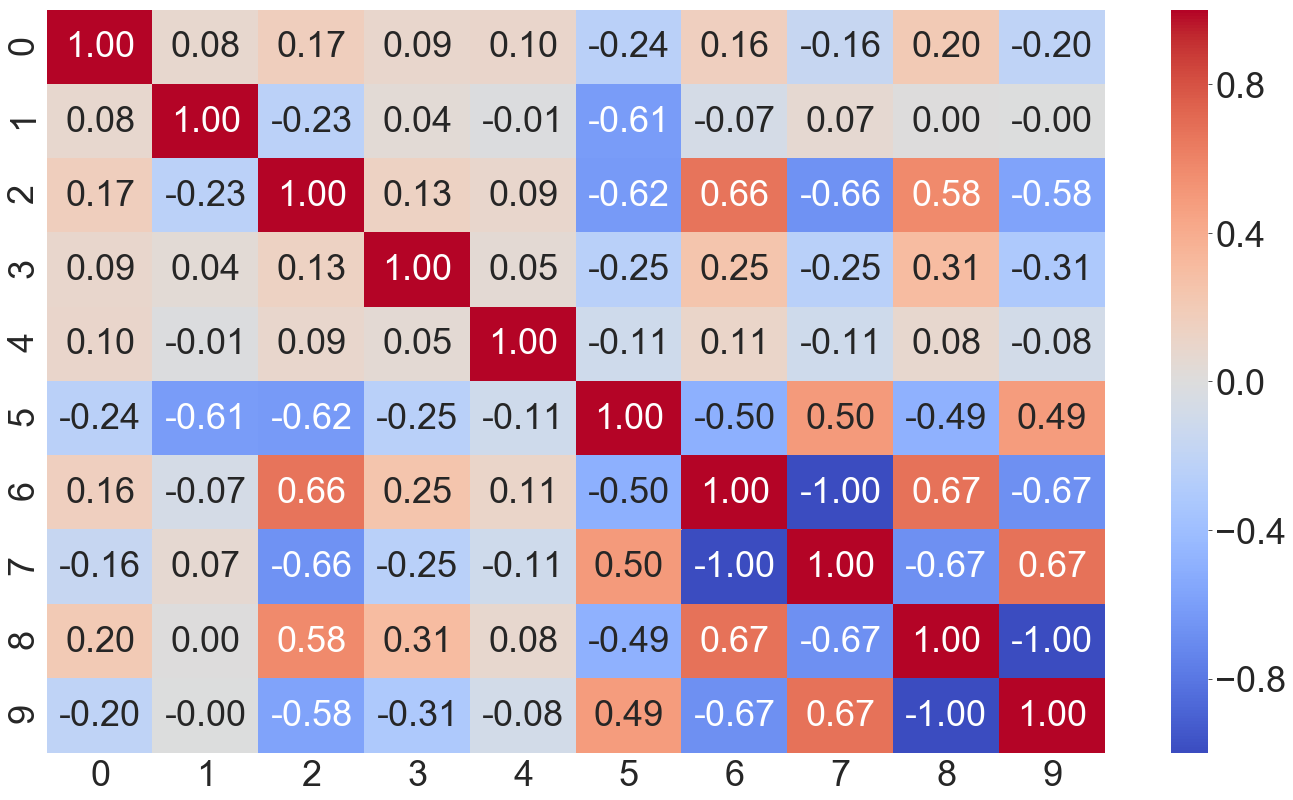

In [85]:
sns.heatmap(np.corrcoef(all_groups_tract_fractions), fmt='.2f', cmap='coolwarm', annot=True)
# plt.xticks(np.arange(10) + 0.5, all_group_names, rotation=90);
# plt.yticks(np.arange(10) + 0.5, all_group_names, rotation=0);
plt.tight_layout()
plt.savefig('visualizations/alameda-cc-characteristics/pearson_correlations_all.png')

### Visualizations with p-values

We want to only visualize correlations with $p < 0.01$. 

In [86]:
from scipy.stats import pearsonr

In [87]:
def get_correlation_matrix(vectors_stack, p_value_cutoff = 0.05): 
    '''
    vectors_stack: 2D array. Rows correspond to the vectors whose pairwise correlations we want to compute. 
    p_value_cutoff: Float. The value above which we don't include the correlations. 
    
    Returns: correlations, p_values, mask. All 2D square arrays of the same shape. 
    Correlations gives pairwise correlations, p_values gives the corresponding p-value for each correlation.
    mask is a bolean array, whose entries tell whether the p-value at that cell meets the cutoff.
    '''
    num_vecs = vectors_stack.shape[0]
    
    # Initialize an empty zeros matrix for correlations, p-values, and the masking array.
    correlations = np.zeros(shape=(num_vecs, num_vecs))
    p_values = np.zeros(shape=(num_vecs, num_vecs))
    mask = np.ones(shape=(num_vecs, num_vecs))
    
    for i in range(num_vecs): 
        # Mask the diagonal by default. 
        # Correlation of a vector with itself is 1.0 always. s
        correlations[i][i] = 1.0
        p_values[i][i] = 0.0
        mask[i][i] = False
        for j in range(i): 
            corr, pval = pearsonr(vectors_stack[i], vectors_stack[j])
            masking_val = (pval > p_value_cutoff)
            
            # update arrays
            correlations[i][j] = corr
            p_values[i][j] = pval
            correlations[j][i] = corr
            p_values[j][i] = pval
            mask[i][j] = mask[j][i] = masking_val
    return correlations, p_values, mask

In [88]:
def get_correlations(list_of_grouping_dfs, total_population_arr, summing = True, p_value_cutoff = 0.01): 
    '''
    Computes correlations along a collection of demographic groupings. 
    
    list_of_grouping_dfs: List or tuple of Pandas dataframes. Each dataframe gives group
    counts at each census tract for a certain notion of grouping, e.g. income or health insurance. 
    total_population_arr: 1D array giving the population at each census tract.
    summing: Boolean. Deprecated. Whether to use the "summing" view of correlations, which we do, 
    or the "averaging" view. 
    
    p_value_cutoff: Float. The value above which we don't include the correlations. 
    
    Returns: correlations, p_values, mask, names_list. All 2D square arrays of the same shape. 
    Correlations gives pairwise correlations, p_values gives the corresponding p-value for each correlation.
    mask is a bolean array, whose entries tell whether the p-value at that cell meets the cutoff.
    names_list is a list of strings, where each entry is the group name for that indexed entry.
    '''
    names_list, group_vecs = [], []
    for df in list_of_grouping_dfs: 
        if summing: 
            names, arrs = get_tract_percentage_arrs(df, total_population_arr)
        else: 
            names, arrs = get_fractional_averaging_arrs(df)
        names_list += names
        group_vecs.append(arrs)
    all_group_vecs = np.vstack(group_vecs)
    corrs, p_values, mask_arr = get_correlation_matrix(all_group_vecs, p_value_cutoff=p_value_cutoff)
    return corrs, p_values, mask_arr, names_list

In [89]:
corrs, p_values, mask_arr, names = get_correlations([race_split_df_all, 
                                                     income_split_df_all, health_ins_split_df_all], 
                                                   total_population_by_tract)

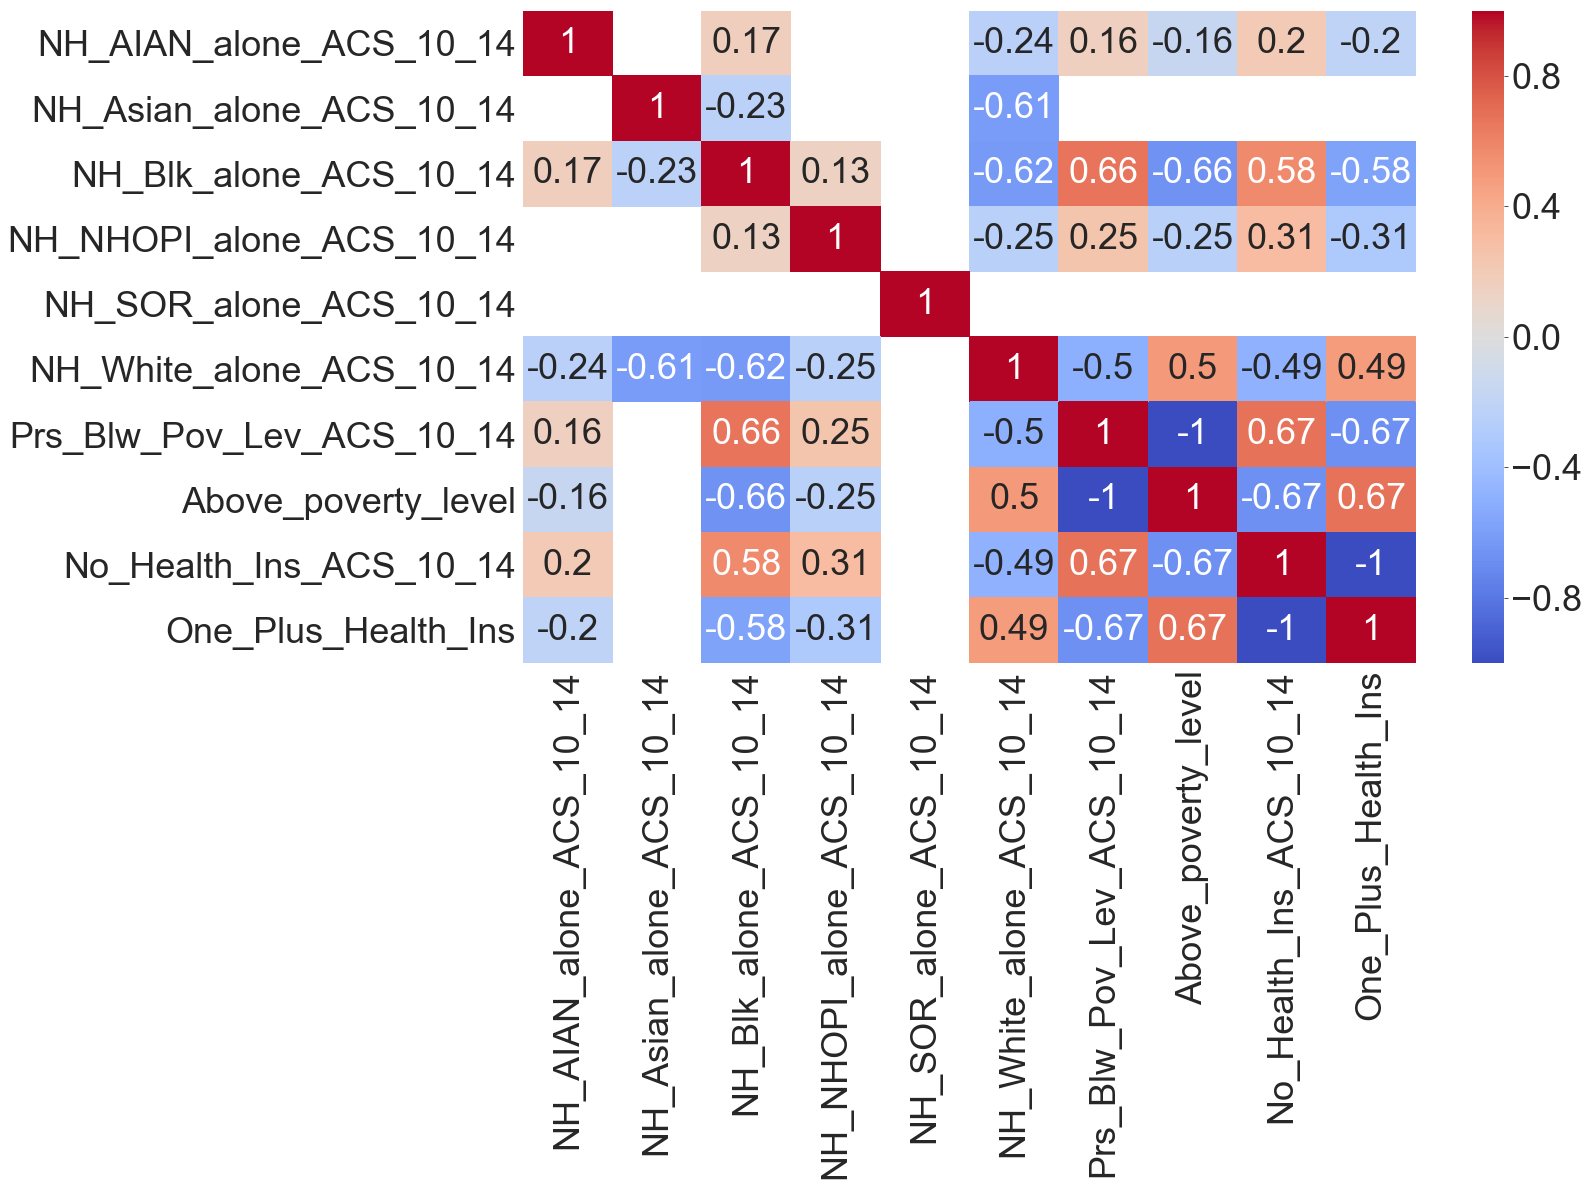

In [90]:
sns.heatmap(corrs, cmap='coolwarm', annot=True, mask=mask_arr)
plt.xticks(np.arange(10) + 0.5, names, rotation=90);
plt.yticks(np.arange(10) + 0.5, names, rotation=0);

In [91]:
def get_lower_triangular(mat): 
    '''
    Gets the lower triangular portion of a 2D array. The rest of the entries are set to 1. 
    
    mat: 2D array of numbers, typically float (Datatype of entries should not matter)
    '''
    out_mat = np.ones(shape=mat.shape)
    for i in range(len(mat)):
        for j in range(len(mat)): 
            if i >= j: 
                out_mat[i][j] = mat[i][j]
    return out_mat

In [92]:
def plot_submatrix(main_matrix, main_mask, sub_indices, row_col_names, savepath=None): 
    '''
    Plots a submatrix of main_matrix according to a masking array. 
    '''
    main_mat = main_matrix[sub_indices][:, sub_indices]
    mask_mat = get_lower_triangular(main_mask[sub_indices][:, sub_indices])
    sns.heatmap(main_mat, cmap='coolwarm', annot=True, mask=mask_mat, vmin=-1.0, vmax=1.0)
    plt.xticks(np.arange(len(row_col_names)) + 0.5, row_col_names, rotation=90);
    plt.yticks(np.arange(len(row_col_names)) + 0.5, row_col_names, rotation=0);
    plt.tight_layout()
    
    if savepath: 
        plt_savefig_safe(savepath)

In [93]:
all_group_names

['NH_AIAN_alone_ACS_10_14',
 'NH_Asian_alone_ACS_10_14',
 'NH_Blk_alone_ACS_10_14',
 'NH_NHOPI_alone_ACS_10_14',
 'NH_SOR_alone_ACS_10_14',
 'NH_White_alone_ACS_10_14',
 'Prs_Blw_Pov_Lev_ACS_10_14',
 'Above_poverty_level',
 'No_Health_Ins_ACS_10_14',
 'One_Plus_Health_Ins']

In [94]:
subset_group_indices = [1, 2, 5, 7, 9]

In [95]:
subset_group_names_clean = ['Asian-Amercian',
 'African-American',
 'White',
 'Above Poverty Line',
 '1+ Health Ins.']

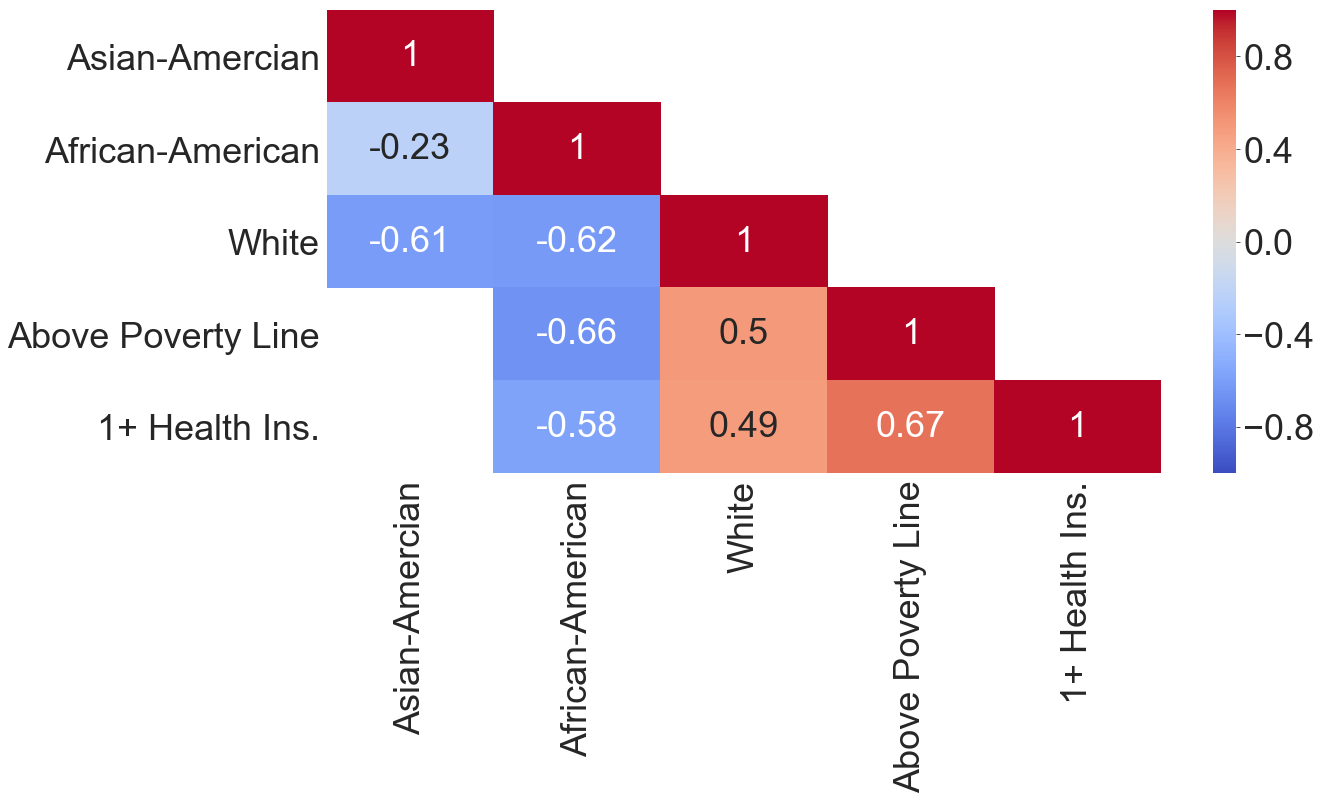

In [96]:
savepath = 'visualizations/alameda-cc-characteristics/pearson_corrs_fig_clean.png'
plot_submatrix(corrs, mask_arr, subset_group_indices, subset_group_names_clean, savepath=savepath)

# Scatterplots

We want to visualize the spatial distributions of different groups in the dataset, such as residents below or above the poverty line. 

In [355]:
def plot_grouping_scatter(split_grouping_df, total_population_by_tract, 
                          colorbar_col_name, group_name_for_title, 
                          colorbar_str_name, colormap_fn, savedir=None, 
                          normalize=False, min_max_normalize=None): 
    '''
    split_grouping_df: census tract split df. 
    total_population_by_tract: 1D Array of floats. The population count at each census tract.
    colorbar_col_name: String. Name of the group we are plotting. Example: "Below_Poverty".
    
    group_name_for_title: Name of the group for title purposes. Doesn't correspond to any 
    dataframe column name. Example: "Percent of Residents Below Poverty Line"
    
    colorbar_str_name: Name of the colormap to use for census tract shading. Must be a valid
    matplotlib colormap. 
    
    colormap_fn: Function of the colormap to use for census tract shading. For example, if 
    colorbar_str_name = 'seismic', then this param should be cm.seismic. 
    
    normalize: Boolean. Whether to normalize the colorbar to min/max percent value in the grouping. 
    
    min_max_normalize: Tuple of floats in [0.0, 1.0] to normalize colorbar with.
    '''
    total_pop_arr = get_total_population(split_grouping_df, 567)
    grouping_df_subset = split_grouping_df[split_grouping_df['Variable'] == colorbar_col_name].copy()
    census_tracts_long_lat = np.array(grouping_df_subset.sort_values(by='Latitude')[['Longitude', 'Latitude']])
    
    group_names, fractional_arrs = get_tract_percentage_arrs(split_grouping_df, total_population_by_tract)
    colorbar_group_percentages = fractional_arrs[group_names.index(colorbar_col_name)]
    
    
    # Calculate colors first.
    colors = colormap_fn(colorbar_group_percentages)
    
    # Plot Census Tracts
    max_pop = max(total_pop_arr)
    max_dot_size = 100.0
    size_scaler = max_dot_size / float(max_pop)
    
    # Set up figure
    plt.figure(figsize=(18, 10))
    
    # Scatterplot (left-hand side)
    # The plot has 1 row and 4 columns. First 3 columns are for the scatterplot. 
    # Rightmost column is for the colorbar. 
    
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    for i in range(len(total_pop_arr)): 
        cur_pop = total_pop_arr[i]
        ax1.scatter(census_tracts_long_lat[i, 0], census_tracts_long_lat[i, 1], 
                    s=cur_pop * size_scaler, color=colors[i])
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    
    cmap_name = colorbar_str_name
    norm = Normalize(vmin=0.0, vmax=1.0)
    if normalize:
        if min_max_normalize:
            assert len(min_max_normalize) == 2, 'Invalid min_max_normalize inputs.'
            norm = Normalize(vmin=min_max_normalize[0], vmax=min_max_normalize[1])
        else:
            norm = Normalize(vmin=min(colorbar_group_percentages), vmax=max(colorbar_group_percentages))

    # Set up colorbar. 
    ax2 = plt.subplot2grid((1, 4), (0, 3))
    colorbar.ColorbarBase(ax2, cmap=cmap_name, norm=norm)
    ax2.set_title('Percentage'.format(colorbar_col_name))
    
    # Suptitle
    #     plt.suptitle('Alameda County: Percent {}'.format(group_name_for_title))
    #     plt.subplots_adjust(top=0.9)
    
    
    # Save Figure            
    if savedir:
        plt.savefig(savedir + 'percent_scatter_{}_{}.png'.format(colorbar_col_name, colorbar_str_name))
    else:
        plt.show()
    plt.close()

In [356]:
savedir = 'visualizations/alameda-cc-characteristics/scatterplots/'

### Test

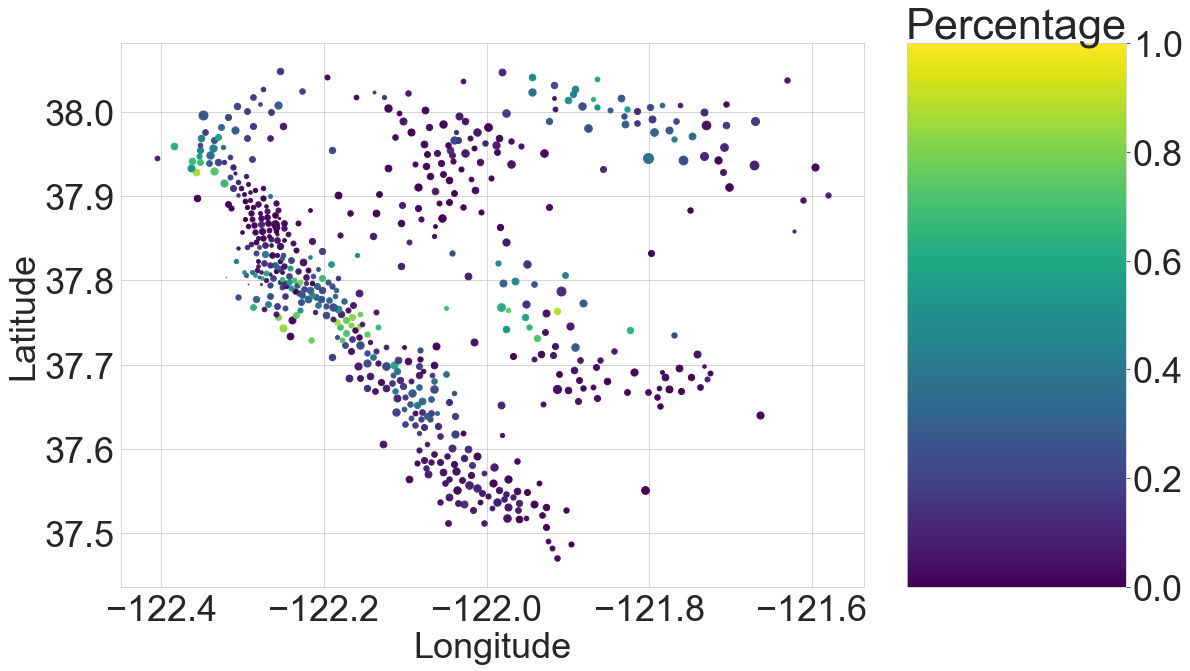

In [358]:
name = all_group_names[2]
clean_name = 'Black'
plot_grouping_scatter(race_split_df_all, total_population_by_tract, name, clean_name, 
                      'viridis', cm.viridis, savedir=None)

### Save plots for all 10 groupings

In [359]:
all_group_names

['NH_AIAN_alone_ACS_10_14',
 'NH_Asian_alone_ACS_10_14',
 'NH_Blk_alone_ACS_10_14',
 'NH_NHOPI_alone_ACS_10_14',
 'NH_SOR_alone_ACS_10_14',
 'NH_White_alone_ACS_10_14',
 'Prs_Blw_Pov_Lev_ACS_10_14',
 'Above_poverty_level',
 'No_Health_Ins_ACS_10_14',
 'One_Plus_Health_Ins']

In [363]:
for group_name in all_group_names[:6]: 
    plot_grouping_scatter(race_split_df_all, total_population_by_tract, group_name, group_name, 
                      'nipy_spectral', cm.nipy_spectral, savedir=savedir)

In [364]:
for group_name in all_group_names[6:8]: 
    plot_grouping_scatter(income_split_df_all, total_population_by_tract,group_name, group_name, 
                      'nipy_spectral', cm.nipy_spectral, savedir=savedir)

In [365]:
for group_name in all_group_names[8:]: 
    plot_grouping_scatter(health_ins_split_df_all, total_population_by_tract, group_name, group_name, 
                      'nipy_spectral', cm.nipy_spectral, savedir=savedir)

## Custom demographic scatterplot. 

Let's repeat the same function, but with no labels and no colorbar. Then, we can create a custom figure for the paper. 

This function is similar to `plot_grouping_scatter`, but rather than plotting and saving a figure, it simply prepares the relevant data for plotting. By plotting outside the function we can make modifications for the custom figure.

In [368]:
def plot_grouping_scatter_setup(split_grouping_df, total_population_by_tract,
                                colorbar_col_name, group_name_for_title, 
                          colorbar_str_name, colormap_fn, savedir=None, 
                          normalize=False, min_max_normalize=None): 
    '''
    split_grouping_df: census tract split df. 
    total_population_by_tract: 1D Array of floats. The population count at each census tract.
    colorbar_col_name: String. Name of the group we are plotting. Example: "Below_Poverty".
    
    group_name_for_title: Name of the group for title purposes. Doesn't correspond to any 
    dataframe column name. Example: "Percent of Residents Below Poverty Line"
    
    colorbar_str_name: Name of the colormap to use for census tract shading. Must be a valid
    matplotlib colormap. 
    
    colormap_fn: Function of the colormap to use for census tract shading. For example, if 
    colorbar_str_name = 'seismic', then this param should be cm.seismic. 
    
    normalize: Boolean. Whether to normalize the colorbar to min/max percent value in the grouping. 
    
    min_max_normalize: Tuple of floats in [0.0, 1.0] to normalize colorbar with.
    '''
    grouping_df_subset = split_grouping_df[split_grouping_df['Variable'] == colorbar_col_name].copy()
    census_tracts_long_lat = np.array(grouping_df_subset.sort_values(by='Latitude')[['Longitude', 'Latitude']])
    
    group_names, fractional_arrs = get_tract_percentage_arrs(split_grouping_df, total_population_by_tract)
    colorbar_group_percentages = fractional_arrs[group_names.index(colorbar_col_name)]
    
    
    # Calculate colors first.
    colors = colormap_fn(colorbar_group_percentages)
    
    # Set Census Tract dot sizes for scatterplot.
    max_pop = max(total_population_by_tract)
    max_dot_size = 150.0
    size_scaler = max_dot_size / float(max_pop)
        
    return total_population_by_tract, census_tracts_long_lat, size_scaler, colors

Now we'll make a grid figure, which contains several subplots that we can position according to certain coordinates. We'll make 4 scatterplots which portray different demographics. Finally, we'll add a colorbar to indicate which colors are higher percentages.

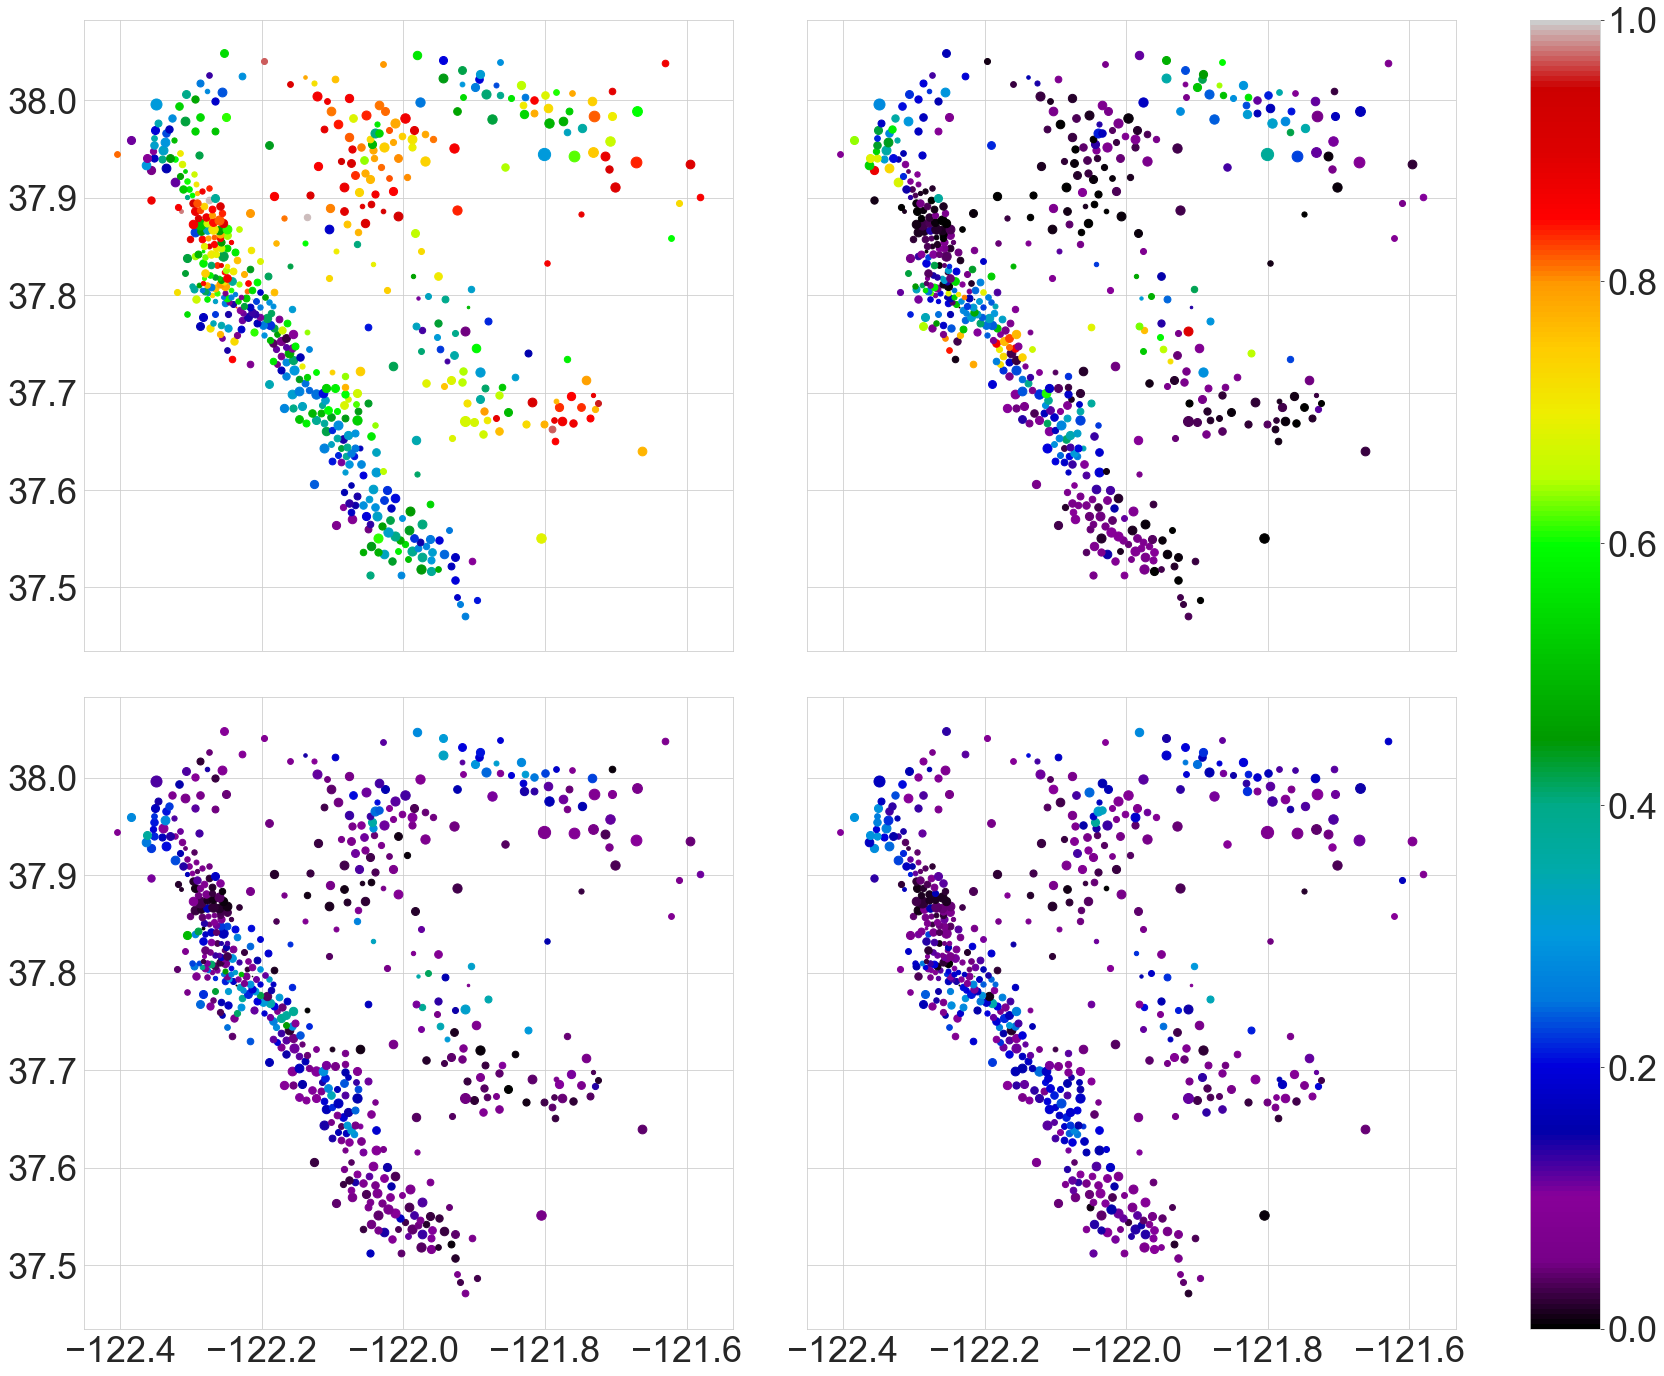

In [371]:
# Figure setup. 
plt.figure(figsize=[24,20])

# Top Left: White residents. 
ax1 = plt.subplot2grid((2, 11), (0, 0), colspan=5)
group_name = 'NH_White_alone_ACS_10_14'
total_pop_arr, census_tracts_long_lat, size_scaler, colors =\
            plot_grouping_scatter_setup(race_split_df_all, total_population_by_tract, group_name, group_name, 
            'nipy_spectral', cm.nipy_spectral)
for i in range(len(total_pop_arr)): 
        cur_pop = total_pop_arr[i]
        ax1.scatter(census_tracts_long_lat[i, 0], census_tracts_long_lat[i, 1], 
                    s=cur_pop * size_scaler, color=colors[i])
# ax1.set_yticklabels([])
ax1.set_xticklabels([])

# Top Right: Black residents. 
ax2 = plt.subplot2grid((2, 11), (0, 5), colspan=5)
group_name = 'NH_Blk_alone_ACS_10_14'
total_pop_arr, census_tracts_long_lat, size_scaler, colors =\
            plot_grouping_scatter_setup(race_split_df_all, total_population_by_tract, group_name, group_name, 
            'nipy_spectral', cm.nipy_spectral)
for i in range(len(total_pop_arr)): 
        cur_pop = total_pop_arr[i]
        ax2.scatter(census_tracts_long_lat[i, 0], census_tracts_long_lat[i, 1], 
                    s=cur_pop * size_scaler, color=colors[i])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Bottom Left: Below poverty line. 
ax3 = plt.subplot2grid((2, 11), (1, 0), colspan=5)
group_name = 'Prs_Blw_Pov_Lev_ACS_10_14'
total_pop_arr, census_tracts_long_lat, size_scaler, colors =\
            plot_grouping_scatter_setup(income_split_df_all, total_population_by_tract, group_name, group_name, 
            'nipy_spectral', cm.nipy_spectral)
for i in range(len(total_pop_arr)): 
        cur_pop = total_pop_arr[i]
        ax3.scatter(census_tracts_long_lat[i, 0], census_tracts_long_lat[i, 1], 
                    s=cur_pop * size_scaler, color=colors[i])
# ax3.set_yticklabels([])
# ax3.set_xticklabels([])

# Bottom right: No health ins.
ax4 = plt.subplot2grid((2, 11), (1, 5), colspan=5)
group_name = 'No_Health_Ins_ACS_10_14'
total_pop_arr, census_tracts_long_lat, size_scaler, colors =\
            plot_grouping_scatter_setup(health_ins_split_df_all, total_population_by_tract, group_name, group_name, 
            'nipy_spectral', cm.nipy_spectral)
for i in range(len(total_pop_arr)): 
        cur_pop = total_pop_arr[i]
        ax4.scatter(census_tracts_long_lat[i, 0], census_tracts_long_lat[i, 1], 
                    s=cur_pop * size_scaler, color=colors[i])
ax4.set_yticklabels([])
# ax4.set_xticklabels([])

# Rightmost: Colorbar. 
cmap_name = 'nipy_spectral'
norm = Normalize(vmin=0.0, vmax=1.0)
ax5 = plt.subplot2grid((2, 11), (0, 10), rowspan=2)
colorbar.ColorbarBase(ax5, cmap=cmap_name, norm=norm);

plt.tight_layout();
plt.savefig('visualizations/alameda-cc-characteristics/demographic_scatterplots_composite_fig.png')

# Extra

## User breakdown by hospital 

What are the percentages and counts of users before/after Alta Bates closes, for each hospital in the dataset? What are these numbers broken down by each demographic field? 

In [53]:
get_ab_grouping_percentages(income_split_df_all, 
                            ab_customers_tract_ids, 
                            np.sum(total_population_by_tract[ab_customers_tract_ids]))

{'Prs_Blw_Pov_Lev_ACS_10_14': 23074,
 'Prs_Blw_Pov_Lev_ACS_10_14_Percentage': 0.1366514068450072,
 'Above_poverty_level': 145779,
 'Above_poverty_level_Percentage': 0.8633485931549928}

In [113]:
def get_user_fields(fac_number, open_fac_ids):
    label_prepend = ''
    if 1 not in open_fac_ids: 
        label_prepend = '_AB_closed'
    tract_ids = get_facility_tract_ids(fac_number, open_fac_ids)
    total_users = np.sum(total_population_by_tract[tract_ids])
    health_ins_percentages = get_ab_grouping_percentages(health_ins_split_df_all, 
                                                        tract_ids,
                                                        total_users)
    income_percentages = get_ab_grouping_percentages(income_split_df_all, 
                                                        tract_ids,
                                                        total_users)
    ethn_percentages = get_ab_grouping_percentages(race_split_df_all, 
                                                  tract_ids,
                                                  total_users)
    out_dict = {'Total_users' + label_prepend: total_users}
    for k in health_ins_percentages: 
        out_dict[k + label_prepend] = health_ins_percentages[k]
    for k in income_percentages: 
        out_dict[k + label_prepend] = income_percentages[k]
    for k in ethn_percentages: 
        out_dict[k + label_prepend] = ethn_percentages[k]
    for k in out_dict: 
        if out_dict[k] >= 0.9999: 
            out_dict[k] = int(out_dict[k])
    return out_dict

In [49]:
cur_facs = [x for x in range(13)] + [x for x in range(17, 25)]

In [61]:
cur_facs_no_ab = [x for x in cur_facs if x != 1]

In [116]:
example_dict_no_ab = get_user_fields(3, cur_facs_no_ab)

In [117]:
example_dict_with_ab = get_user_fields(3, cur_facs)

In [119]:
example_dict_no_ab

{'Total_users_AB_closed': 184963,
 'No_Health_Ins_ACS_10_14_AB_closed': 28680,
 'No_Health_Ins_ACS_10_14_Percentage_AB_closed': 0.15506143987811136,
 'One_Plus_Health_Ins_AB_closed': 156282,
 'One_Plus_Health_Ins_Percentage_AB_closed': 0.8449385601218886,
 'Prs_Blw_Pov_Lev_ACS_10_14_AB_closed': 35817,
 'Prs_Blw_Pov_Lev_ACS_10_14_Percentage_AB_closed': 0.19364413423225185,
 'Above_poverty_level_AB_closed': 149146,
 'Above_poverty_level_Percentage_AB_closed': 0.8063558657677481,
 'NH_AIAN_alone_ACS_10_14_AB_closed': 1088,
 'NH_AIAN_alone_ACS_10_14_Percentage_AB_closed': 0.005882257532587598,
 'NH_Asian_alone_ACS_10_14_AB_closed': 56238,
 'NH_Asian_alone_ACS_10_14_Percentage_AB_closed': 0.3040540480681299,
 'NH_Blk_alone_ACS_10_14_AB_closed': 60408,
 'NH_Blk_alone_ACS_10_14_Percentage_AB_closed': 0.326598522969861,
 'NH_NHOPI_alone_ACS_10_14_AB_closed': 2170,
 'NH_NHOPI_alone_ACS_10_14_Percentage_AB_closed': 0.011732076144958721,
 'NH_SOR_alone_ACS_10_14_AB_closed': 750,
 'NH_SOR_alone_AC

In [118]:
example_dict_with_ab

{'Total_users': 184963,
 'No_Health_Ins_ACS_10_14': 28680,
 'No_Health_Ins_ACS_10_14_Percentage': 0.15506143987811136,
 'One_Plus_Health_Ins': 156282,
 'One_Plus_Health_Ins_Percentage': 0.8449385601218886,
 'Prs_Blw_Pov_Lev_ACS_10_14': 35817,
 'Prs_Blw_Pov_Lev_ACS_10_14_Percentage': 0.19364413423225185,
 'Above_poverty_level': 149146,
 'Above_poverty_level_Percentage': 0.8063558657677481,
 'NH_AIAN_alone_ACS_10_14': 1088,
 'NH_AIAN_alone_ACS_10_14_Percentage': 0.005882257532587598,
 'NH_Asian_alone_ACS_10_14': 56238,
 'NH_Asian_alone_ACS_10_14_Percentage': 0.3040540480681299,
 'NH_Blk_alone_ACS_10_14': 60408,
 'NH_Blk_alone_ACS_10_14_Percentage': 0.326598522969861,
 'NH_NHOPI_alone_ACS_10_14': 2170,
 'NH_NHOPI_alone_ACS_10_14_Percentage': 0.011732076144958721,
 'NH_SOR_alone_ACS_10_14': 750,
 'NH_SOR_alone_ACS_10_14_Percentage': 0.004054865027059466,
 'NH_White_alone_ACS_10_14': 64308,
 'NH_White_alone_ACS_10_14_Percentage': 0.3476836367441061}

In [121]:
fac_df_with_user_counts = total_fac_df.copy()

In [122]:
for k in example_dict_with_ab: 
    fac_df_with_user_counts[k] = None

In [123]:
for k in example_dict_no_ab: 
    fac_df_with_user_counts[k] = None

In [125]:
fac_df_with_user_counts.at[3, 'Total_users'] = 111

In [127]:
for fac_number in cur_facs: 
    dict_with_ab = get_user_fields(fac_number, cur_facs)
    for k in dict_with_ab:
        fac_df_with_user_counts.at[fac_number, k] = dict_with_ab[k]

In [129]:
fac_df_with_user_counts

LONGITUDE   LATITUDE                                      FACILITY_NAME  \
0  -122.253991  37.762660                                   ALAMEDA HOSPITAL   
1  -122.257430  37.856450  ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...   
2  -122.267470  37.837220  CHILDRENS HOSPITAL AND RESEARCH CENTER AT OAKLAND   
3  -122.231380  37.799250                                  HIGHLAND HOSPITAL   
4  -122.262570  37.821060                   ALTA BATES SUMMIT MEDICAL CENTER   
5  -122.089620  37.632910                                  ST. ROSE HOSPITAL   
6  -121.980060  37.558470                      WASHINGTON HOSPITAL - FREMONT   
7  -122.140670  37.713640                               SAN LEANDRO HOSPITAL   
8  -121.880950  37.692060                          VALLEYCARE MEDICAL CENTER   
9  -121.974830  37.550550               KAISER FOUNDATION HOSPITAL - FREMONT   
10 -122.087405  37.698377                                EDEN MEDICAL CENTER   
11 -122.257910  37.824020      KAISER FOUNDATION HOSPITAL - OAKLAND/RICHMOND   
12 -122.169170  37.706110           KAISER FOUNDATION HOSPITAL - SAN LEANDRO   
13 -122.118190  37.706480                                  FAIRMONT HOSPITAL   
14 -122.269840  37.863730    ALTA BATES SUMMIT MEDICAL CENTER-HERRICK CAMPUS   
15 -122.131190  37.716210          KINDRED HOSPITAL - SAN FRANCISCO BAY AREA   
16 -121.782520  37.678700                           VALLEY MEMORIAL HOSPITAL   
17 -121.802711  37.982660                        SUTTER DELTA MEDICAL CENTER   
18 -122.041361  37.912610       JOHN MUIR MEDICAL CENTER-WALNUT CREEK CAMPUS   
19 -122.058681  37.891380          KAISER FOUNDATION HOSPITAL - WALNUT CREEK   
20 -122.361041  37.937110       KAISER FOUNDATION HOSPITAL - RICHMOND CAMPUS   
21 -122.132641  38.006740               CONTRA COSTA REGIONAL MEDICAL CENTER   
22 -122.033301  37.982670            JOHN MUIR MEDICAL CENTER-CONCORD CAMPUS   
23 -121.958761  37.775990                  SAN RAMON REGIONAL MEDICAL CENTER   
24 -121.775621  37.950640               KAISER FOUNDATION HOSPITAL - ANTIOCH   

    TOTAL_NUMBER_BEDS Total_users No_Health_Ins_ACS_10_14  \
0                 135       95977                   13925   
1                 347      168853                   11173   
2                 190       42838                    5839   
3                 249      184963                   28680   
4                 403       56587                    9750   
5                 217      168717                   26141   
6                 341      168692                   15096   
7                  93      125111                   19140   
8                 167      202948                   14782   
9                 106      130773                    9255   
10                130      141291                   18268   
11                315       29595                    1888   
12                216       56190                    9115   
13                159        None                    None   
14                 69        None                    None   
15                 99        None                    None   
16                 75        None                    None   
17                145      114300                   18317   
18                554       85651                    7679   
19                233       90578                    4556   
20                 50      236442                   39761   
21                167       65445                    5909   
22                244      187480                   25005   
23                123      132844                    5305   
24                150      155265                   14631   

   No_Health_Ins_ACS_10_14_Percentage One_Plus_Health_Ins  \
0                            0.145087               82052   
1                           0.0661733              157679   
2                            0.136304               36999   
3                            0.155061              156282   
4                            0.1

In [130]:
for fac_number in cur_facs_no_ab: 
    dict_no_ab = get_user_fields(fac_number, cur_facs_no_ab)
    for k in dict_no_ab:
        fac_df_with_user_counts.at[fac_number, k] = dict_no_ab[k]

In [131]:
fac_df_with_user_counts

LONGITUDE   LATITUDE                                      FACILITY_NAME  \
0  -122.253991  37.762660                                   ALAMEDA HOSPITAL   
1  -122.257430  37.856450  ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...   
2  -122.267470  37.837220  CHILDRENS HOSPITAL AND RESEARCH CENTER AT OAKLAND   
3  -122.231380  37.799250                                  HIGHLAND HOSPITAL   
4  -122.262570  37.821060                   ALTA BATES SUMMIT MEDICAL CENTER   
5  -122.089620  37.632910                                  ST. ROSE HOSPITAL   
6  -121.980060  37.558470                      WASHINGTON HOSPITAL - FREMONT   
7  -122.140670  37.713640                               SAN LEANDRO HOSPITAL   
8  -121.880950  37.692060                          VALLEYCARE MEDICAL CENTER   
9  -121.974830  37.550550               KAISER FOUNDATION HOSPITAL - FREMONT   
10 -122.087405  37.698377                                EDEN MEDICAL CENTER   
11 -122.257910  37.824020      KAISER FOUNDATION HOSPITAL - OAKLAND/RICHMOND   
12 -122.169170  37.706110           KAISER FOUNDATION HOSPITAL - SAN LEANDRO   
13 -122.118190  37.706480                                  FAIRMONT HOSPITAL   
14 -122.269840  37.863730    ALTA BATES SUMMIT MEDICAL CENTER-HERRICK CAMPUS   
15 -122.131190  37.716210          KINDRED HOSPITAL - SAN FRANCISCO BAY AREA   
16 -121.782520  37.678700                           VALLEY MEMORIAL HOSPITAL   
17 -121.802711  37.982660                        SUTTER DELTA MEDICAL CENTER   
18 -122.041361  37.912610       JOHN MUIR MEDICAL CENTER-WALNUT CREEK CAMPUS   
19 -122.058681  37.891380          KAISER FOUNDATION HOSPITAL - WALNUT CREEK   
20 -122.361041  37.937110       KAISER FOUNDATION HOSPITAL - RICHMOND CAMPUS   
21 -122.132641  38.006740               CONTRA COSTA REGIONAL MEDICAL CENTER   
22 -122.033301  37.982670            JOHN MUIR MEDICAL CENTER-CONCORD CAMPUS   
23 -121.958761  37.775990                  SAN RAMON REGIONAL MEDICAL CENTER   
24 -121.775621  37.950640               KAISER FOUNDATION HOSPITAL - ANTIOCH   

    TOTAL_NUMBER_BEDS Total_users No_Health_Ins_ACS_10_14  \
0                 135       95977                   13925   
1                 347      168853                   11173   
2                 190       42838                    5839   
3                 249      184963                   28680   
4                 403       56587                    9750   
5                 217      168717                   26141   
6                 341      168692                   15096   
7                  93      125111                   19140   
8                 167      202948                   14782   
9                 106      130773                    9255   
10                130      141291                   18268   
11                315       29595                    1888   
12                216       56190                    9115   
13                159        None                    None   
14                 69        None                    None   
15                 99        None                    None   
16                 75        None                    None   
17                145      114300                   18317   
18                554       85651                    7679   
19                233       90578                    4556   
20                 50      236442                   39761   
21                167       65445                    5909   
22                244      187480                   25005   
23                123      132844                    5305   
24                150      155265                   14631   

   No_Health_Ins_ACS_10_14_Percentage One_Plus_Health_Ins  \
0                            0.145087               82052   
1                           0.0661733              157679   
2                            0.136304               36999   
3                            0.155061              156282   
4                            0.1

In [132]:
fac_df_with_user_counts.to_csv('all-data/facilities_with_user_counts.csv')

In [133]:
fac_df_with_user_counts.columns.values

array(['LONGITUDE', 'LATITUDE', 'FACILITY_NAME', 'TOTAL_NUMBER_BEDS',
       'Total_users', 'No_Health_Ins_ACS_10_14',
       'No_Health_Ins_ACS_10_14_Percentage', 'One_Plus_Health_Ins',
       'One_Plus_Health_Ins_Percentage', 'Prs_Blw_Pov_Lev_ACS_10_14',
       'Prs_Blw_Pov_Lev_ACS_10_14_Percentage', 'Above_poverty_level',
       'Above_poverty_level_Percentage', 'NH_AIAN_alone_ACS_10_14',
       'NH_AIAN_alone_ACS_10_14_Percentage', 'NH_Asian_alone_ACS_10_14',
       'NH_Asian_alone_ACS_10_14_Percentage', 'NH_Blk_alone_ACS_10_14',
       'NH_Blk_alone_ACS_10_14_Percentage', 'NH_NHOPI_alone_ACS_10_14',
       'NH_NHOPI_alone_ACS_10_14_Percentage', 'NH_SOR_alone_ACS_10_14',
       'NH_SOR_alone_ACS_10_14_Percentage', 'NH_White_alone_ACS_10_14',
       'NH_White_alone_ACS_10_14_Percentage', 'Total_users_AB_closed',
       'No_Health_Ins_ACS_10_14_AB_closed',
       'No_Health_Ins_ACS_10_14_Percentage_AB_closed',
       'One_Plus_Health_Ins_AB_closed',
       'One_Plus_Health_Ins_Percen

In [135]:
fac_df_with_user_counts[[
    'LONGITUDE', 'LATITUDE', 'FACILITY_NAME', 'TOTAL_NUMBER_BEDS',
       'Total_users', 'No_Health_Ins_ACS_10_14',
       'No_Health_Ins_ACS_10_14_Percentage',
    'Total_users_AB_closed',
       'No_Health_Ins_ACS_10_14_AB_closed',
       'No_Health_Ins_ACS_10_14_Percentage_AB_closed'
]].to_csv('all-data/facilites_with_user_counts_health_ins_data.csv')

In [136]:
fac_df_with_user_counts[[
    'LONGITUDE', 'LATITUDE', 'FACILITY_NAME', 'TOTAL_NUMBER_BEDS',
       'Total_users', 'No_Health_Ins_ACS_10_14',
       'No_Health_Ins_ACS_10_14_Percentage',
    'Total_users_AB_closed',
       'No_Health_Ins_ACS_10_14_AB_closed',
       'No_Health_Ins_ACS_10_14_Percentage_AB_closed'
]]

LONGITUDE   LATITUDE                                      FACILITY_NAME  \
0  -122.253991  37.762660                                   ALAMEDA HOSPITAL   
1  -122.257430  37.856450  ALTA BATES SUMMIT MEDICAL CENTER-ALTA BATES CA...   
2  -122.267470  37.837220  CHILDRENS HOSPITAL AND RESEARCH CENTER AT OAKLAND   
3  -122.231380  37.799250                                  HIGHLAND HOSPITAL   
4  -122.262570  37.821060                   ALTA BATES SUMMIT MEDICAL CENTER   
5  -122.089620  37.632910                                  ST. ROSE HOSPITAL   
6  -121.980060  37.558470                      WASHINGTON HOSPITAL - FREMONT   
7  -122.140670  37.713640                               SAN LEANDRO HOSPITAL   
8  -121.880950  37.692060                          VALLEYCARE MEDICAL CENTER   
9  -121.974830  37.550550               KAISER FOUNDATION HOSPITAL - FREMONT   
10 -122.087405  37.698377                                EDEN MEDICAL CENTER   
11 -122.257910  37.824020      KAISER FOUNDATION HOSPITAL - OAKLAND/RICHMOND   
12 -122.169170  37.706110           KAISER FOUNDATION HOSPITAL - SAN LEANDRO   
13 -122.118190  37.706480                                  FAIRMONT HOSPITAL   
14 -122.269840  37.863730    ALTA BATES SUMMIT MEDICAL CENTER-HERRICK CAMPUS   
15 -122.131190  37.716210          KINDRED HOSPITAL - SAN FRANCISCO BAY AREA   
16 -121.782520  37.678700                           VALLEY MEMORIAL HOSPITAL   
17 -121.802711  37.982660                        SUTTER DELTA MEDICAL CENTER   
18 -122.041361  37.912610       JOHN MUIR MEDICAL CENTER-WALNUT CREEK CAMPUS   
19 -122.058681  37.891380          KAISER FOUNDATION HOSPITAL - WALNUT CREEK   
20 -122.361041  37.937110       KAISER FOUNDATION HOSPITAL - RICHMOND CAMPUS   
21 -122.132641  38.006740               CONTRA COSTA REGIONAL MEDICAL CENTER   
22 -122.033301  37.982670            JOHN MUIR MEDICAL CENTER-CONCORD CAMPUS   
23 -121.958761  37.775990                  SAN RAMON REGIONAL MEDICAL CENTER   
24 -121.775621  37.950640               KAISER FOUNDATION HOSPITAL - ANTIOCH   

    TOTAL_NUMBER_BEDS Total_users No_Health_Ins_ACS_10_14  \
0                 135       95977                   13925   
1                 347      168853                   11173   
2                 190       42838                    5839   
3                 249      184963                   28680   
4                 403       56587                    9750   
5                 217      168717                   26141   
6                 341      168692                   15096   
7                  93      125111                   19140   
8                 167      202948                   14782   
9                 106      130773                    9255   
10                130      141291                   18268   
11                315       29595                    1888   
12                216       56190                    9115   
13                159        None                    None   
14                 69        None                    None   
15                 99        None                    None   
16                 75        None                    None   
17                145      114300                   18317   
18                554       85651                    7679   
19                233       90578                    4556   
20                 50      236442                   39761   
21                167       65445                    5909   
22                244      187480                   25005   
23                123      132844                    5305   
24                150      155265                   14631   

   No_Health_Ins_ACS_10_14_Percentage Total_users_AB_closed  \
0                            0.145087                 95977   
1                           0.0661733                  None   
2                            0.136304                183231   
3                            0.155061                184963   
4                     